# VARLiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [80]:
import numpy as np

# 定义矩阵 B0
B0 = np.array([[0, 0, 0],
               [1, 0, 0],
               [0, 1, 0]])

# 定义矩阵 B1
B1 = np.array([[0.9, 0, 0],
               [0, 0.9, 0],
               [0, 0, 0.9]])

# 计算矩阵 M1 = (I - B0)^(-1) * B1
I = np.eye(3)  # 3x3 单位矩阵
invB0 = np.linalg.inv(I - B0)
M1 = invB0.dot(B1)

print("B0:")
print(B0)
print("\nB1:")
print(B1)
print("\ninvB0:")
print(invB0)

print("\nM1:")
print(M1)


B0:
[[0 0 0]
 [1 0 0]
 [0 1 0]]

B1:
[[0.9 0.  0. ]
 [0.  0.9 0. ]
 [0.  0.  0.9]]

invB0:
[[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]

M1:
[[0.9 0.  0. ]
 [0.9 0.9 0. ]
 [0.9 0.9 0.9]]


In [77]:
import numpy as np

# 原始数据集
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Bootstrap参数
n_iterations = 1000
n_size = len(data)

# 用于存储每次迭代的均值
means = []

# 进行bootstrap抽样
for _ in range(n_iterations):
    # 有放回抽样
    sample = np.random.choice(data, size=n_size, replace=True)
    # 计算样本均值
    sample_mean = np.mean(sample)
    # 存储均值
    means.append(sample_mean)

# 计算95%置信区间
alpha = 0.95
lower = np.percentile(means, (1 - alpha) / 2 * 100)
upper = np.percentile(means, (1 + alpha) / 2 * 100)
#print(means)
print(f'95% 置信区间: [{lower:.2f}, {upper:.2f}]')


95% 置信区间: [3.80, 7.30]


In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from lingam import VARLiNGAM

# 生成示例数据
np.random.seed(0)
n = 1000
X1 = np.random.rand(n)
X2 = 2 * X1 + np.random.rand(n) * 0.1
X3 = -3 * X2 + np.random.rand(n) * 0.1
X4 = 0.5 * X1 + 0.2 * X3 + np.random.rand(n) * 0.1
X = np.column_stack((X1, X2, X3, X4))
print(X)

# 创建DataFrame并添加滞后项
df = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4'])
df_lagged = pd.concat([df.shift(i) for i in range(1, 3)], axis=1)
df_lagged.columns = [f"{col}_lag{i}" for i in range(1, 3) for col in df.columns] 
df_combined = pd.concat([df, df_lagged], axis=1).dropna()#12列

# 检查平稳性
def check_stationarity(df):
    for column in df.columns:
        result = adfuller(df[column])
        print(f'{column}: p-value = {result[1]}')
        if result[1] > 0.05:
            print(f'{column} is not stationary')
        else:
            print(f'{column} is stationary')

check_stationarity(df_combined)

# 如果不平稳，可以进行差分处理
# df_diff = df_combined.diff().dropna()
# check_stationarity(df_diff)

# 进行标准化处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)

# 使用PCA降维
pca = PCA(n_components=4)  # 选择合适的主成分数量
X_pca = pca.fit_transform(X_scaled)

# 应用VARLiNGAM模型
model = VARLiNGAM()
model.fit(X_pca)

# 输出因果顺序和邻接矩阵
print("Causal ordering:", model.causal_order_)
print("Adjacency matrix:")
print(model.adjacency_matrices_[0])


[[ 0.549  1.157 -3.39  -0.362]
 [ 0.715  1.431 -4.247 -0.429]
 [ 0.603  1.253 -3.707 -0.362]
 ...
 [ 0.938  1.925 -5.742 -0.596]
 [ 0.229  0.522 -1.484 -0.089]
 [ 0.677  1.404 -4.144 -0.459]]
X1: p-value = 0.0
X1 is stationary
X2: p-value = 0.0
X2 is stationary
X3: p-value = 0.0
X3 is stationary
X4: p-value = 3.409611970282074e-30
X4 is stationary
X1_lag1: p-value = 0.0
X1_lag1 is stationary
X2_lag1: p-value = 0.0
X2_lag1 is stationary
X3_lag1: p-value = 0.0
X3_lag1 is stationary
X4_lag1: p-value = 3.365333102113343e-30
X4_lag1 is stationary
X1_lag2: p-value = 0.0
X1_lag2 is stationary
X2_lag2: p-value = 0.0
X2_lag2 is stationary
X3_lag2: p-value = 0.0
X3_lag2 is stationary
X4_lag2: p-value = 3.3336032333773806e-30
X4_lag2 is stationary
Causal ordering: [2, 1, 0, 3]
Adjacency matrix:
[[   0.       0.      -0.997    0.   ]
 [   0.       0.       0.08     0.   ]
 [   0.       0.       0.       0.   ]
 [-561.78  -471.63  -522.586    0.   ]]


In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.26.3', '2.2.2', '0.20.3', '1.8.3']


## Test data
We create test data consisting of 5 variables.

                  x0        x1        x2        x3
1999-05-28  0.009763  0.044990  0.029551  0.014887
1999-05-29 -0.015269  0.026125 -0.007258  0.076903
1999-05-30  0.092733 -0.004765  0.057392  0.017257
1999-05-31  0.087795  0.098866 -0.023160 -0.067199
1999-06-01 -0.025720  0.140473  0.083745  0.034512


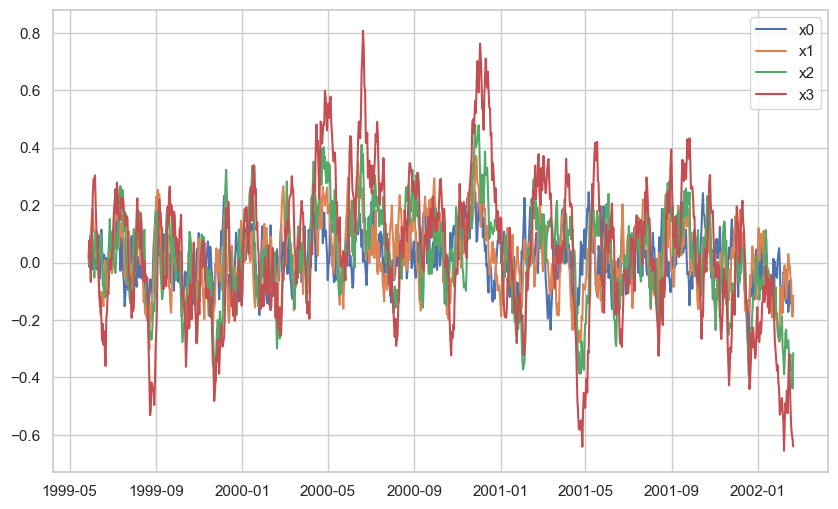

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For heatmap visualization
import warnings  # For ignoring warnings

from lingam import VARLiNGAM  # For VAR-LiNGAM model
from sklearn.preprocessing import StandardScaler  # For preprocessing (standardization)
from scipy import stats  # For normality tests (Shapiro-Wilk test)

warnings.simplefilter('ignore')  # Ignore warnings
plt.rcParams["font.family"] = "MS Gothic"  # For using Japanese fonts in matplotlib

# VAR-LiNGAM artificial data generation function
def VARLiNGAM_generate(adj:np.ndarray, noise:np.ndarray):
    d0, n_features, _ = adj.shape
    lags = d0 - 1
    n_samples = noise.shape[0]
    
    # Generate
    out = np.copy(noise)
    B = np.linalg.inv(np.eye(n_features) - adj[0])

    for i in range(lags):
        out[i] = B @ out[i]
    for i in range(lags, n_samples):
        for tau in range(1, lags + 1):
            out[i] += adj[tau] @ out[i-tau]
        out[i] = B @ out[i]
    
    return out

# Define the adjacency matrices (B0, B1, B2, B3)
adj_varlingam = np.array([
    # B0 (contemporaneous effects)
    [[  0,   0,   0,   0],
     [0.2,   0,   0,   0],
     [  0, 0.2,   0,   0],
     [  0,   0, 0.2,   0]],
    
    # B1 (lagged effects from one time step ago)
    [[0.8,   0,   0,   0],
     [  0, 0.8,   0,   0],
     [  0,   0, 0.8,   0],
     [  0,   0,   0, 0.8]],
     
    # B2 (lagged effects from two time steps ago)
    [[  0,   0,   0,   0],
     [  0,   0,   0,   0],
     [0.2,   0,   0,   0],
     [  0, 0.2,   0,   0]],
     
    # B3 (lagged effects from three time steps ago)
    [[  0,   0,   0,   0],
     [  0,   0,   0,   0],
     [  0,   0,   0,   0],
     [0.1,   0,   0,   0]]
])

# Generate noise
n_samples = 1000
n_features = 4
np.random.seed(0)
noise = np.random.uniform(low=-0.1, high=0.1, size=(n_samples, n_features))

# Generate the data using VARLiNGAM_generate function
X_varlingam = VARLiNGAM_generate(adj=adj_varlingam, noise=noise)

# Create a DataFrame with the generated data
df = pd.DataFrame(data=X_varlingam, index=pd.date_range(start='1999-05-28', periods=n_samples, freq='D'), columns=[f'x{i}' for i in range(n_features)])

# Display the first 5 rows of the DataFrame
print(df.head(5))

# Optional: Visualize the data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i in range(n_features):
    plt.plot(df[f'x{i}'], label=f'x{i}')
plt.legend()
plt.show()


                  x0        x1        x2        x3        x4
1999-05-28  0.035193  0.562784  0.221842 -0.028351 -0.167065
1999-05-29  0.400052 -0.406275  1.315005  2.625972 -0.244863
1999-05-30  1.894124 -1.235670 -0.305898  1.857558 -1.658125
1999-05-31 -1.284104 -4.262668  0.674440  1.391831  1.134318
1999-06-01  3.831299  2.150067 -0.880344  1.108525 -0.840495


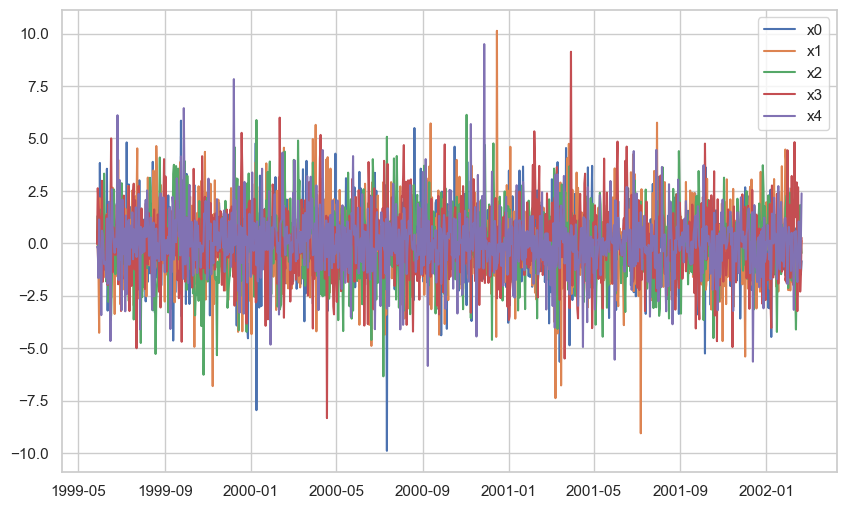

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For heatmap visualization
import warnings  # For ignoring warnings

from lingam import VARLiNGAM  # For VAR-LiNGAM model
from sklearn.preprocessing import StandardScaler  # For preprocessing (standardization)
from scipy import stats  # For normality tests (Shapiro-Wilk test)

warnings.simplefilter('ignore')  # Ignore warnings
plt.rcParams["font.family"] = "MS Gothic"  # For using Japanese fonts in matplotlib

# VAR-LiNGAM artificial data generation function
def VARLiNGAM_generate(B0: np.ndarray, B1: np.ndarray, noise: np.ndarray):
    n_samples, n_features = noise.shape
    
    # Initialize output array
    out = np.zeros((n_samples, n_features))
    
    # Apply B0 to the initial noise terms
    out[0] = np.linalg.inv(np.eye(n_features) - B0) @ noise[0]
    
    # Generate data for subsequent time steps
    for t in range(1, n_samples):
        out[t] = np.dot(B1, out[t-1]) + noise[t]
        out[t] = np.linalg.inv(np.eye(n_features) - B0) @ out[t]
    
    return out

# Given matrices B0 and B1
B0 = np.array([
    [0, -0.12, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [-0.41, 0.01, 0, -0.02, 0],
    [0.04, -0.22, 0, 0, 0],
    [0.15, 0, -0.03, 0, 0],
])

B1 = np.array([
    [-0.32, 0, 0.12, 0.32, 0],
    [0, -0.35, -0.1, -0.46, 0.4],
    [0, 0, 0.37, 0, 0.46],
    [-0.38, -0.1, -0.24, 0, -0.13],
    [0, 0, 0, 0, 0],
])

# Generate noise
n_samples = 1000
n_features = B0.shape[0]
np.random.seed(0)
noise = np.random.laplace(size=(n_samples, n_features))  # Using Laplace distribution for non-Gaussianity

# Generate the data using VARLiNGAM_generate function
X_varlingam = VARLiNGAM_generate(B0=B0, B1=B1, noise=noise)

# Create a DataFrame with the generated data
df = pd.DataFrame(data=X_varlingam, index=pd.date_range(start='1999-05-28', periods=n_samples, freq='D'), columns=[f'x{i}' for i in range(n_features)])

# Display the first 5 rows of the DataFrame
print(df.head(5))

# Optional: Visualize the data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i in range(n_features):
    plt.plot(df[f'x{i}'], label=f'x{i}')
plt.legend()
plt.show()


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For heatmap visualization
import warnings  # For ignoring warnings

from sklearn.preprocessing import StandardScaler  # For preprocessing (standardization)
from scipy import stats  # For normality tests (Shapiro-Wilk test)

warnings.simplefilter('ignore')  # Ignore warnings
plt.rcParams["font.family"] = "MS Gothic"  # For using Japanese fonts in matplotlib

# VAR-LiNGAM artificial data generation function
def VARLiNGAM_generate(B0: np.ndarray, B1: np.ndarray, noise: np.ndarray):
    n_samples, n_features = noise.shape
    
    # Initialize output array
    out = np.zeros((n_samples, n_features))
    
    # Apply B0 to the initial noise terms
    out[0] = np.linalg.inv(np.eye(n_features) - B0) @ noise[0]
    
    # Generate data for subsequent time steps
    for t in range(1, n_samples):
        out[t] = np.dot(B1, out[t-1]) + noise[t]
        out[t] = np.linalg.inv(np.eye(n_features) - B0) @ out[t]
    
    return out

# Parameters
n_samples = 10000  # 1 million data points
n_features = 1000  # 10,000 variables

# Initialize B0 and B1 for large dimensions
np.random.seed(0)
B0 = np.zeros((n_features, n_features))
B1 = np.zeros((n_features, n_features))

# Randomly generate some non-zero entries for B0 and B1 to simulate real conditions
num_connections = n_features // 250  # Adjust the sparsity
for i in range(n_features):
    B0[i, np.random.choice(n_features, num_connections, replace=False)] = np.random.uniform(-0.5, 0.5, num_connections)
    B1[i, np.random.choice(n_features, num_connections, replace=False)] = np.random.uniform(-0.5, 0.5, num_connections)



Elapsed time: 767.385002374649 seconds


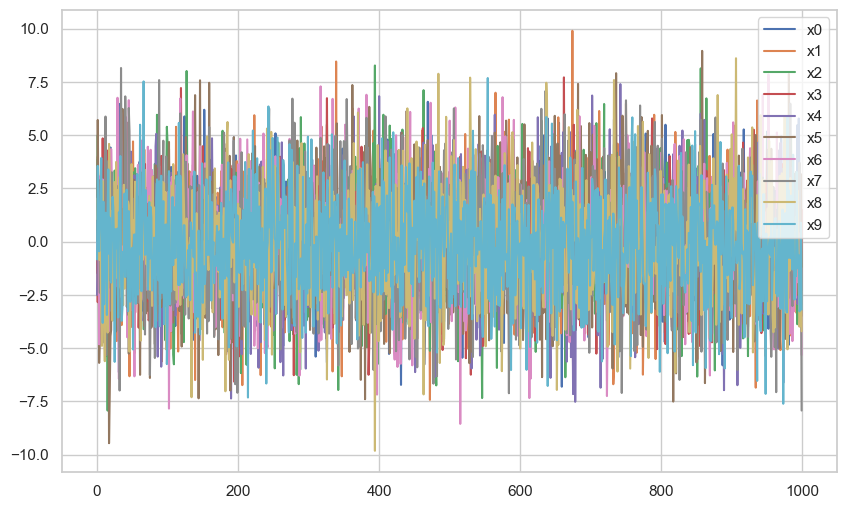

In [127]:
import time
# Generate noise
noise = np.random.laplace(size=(n_samples, n_features)).astype(np.float32)  # Using Laplace distribution for non-Gaussianity
start_time = time.time()
# Generate the data using VARLiNGAM_generate function
# Note: This will consume a lot of memory and might take considerable time
X_varlingam = VARLiNGAM_generate(B0=B0, B1=B1, noise=noise)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
# Create a DataFrame with the generated data (optional, might be too large to handle efficiently)
# df = pd.DataFrame(data=X_varlingam, columns=[f'x{i}' for i in range(n_features)])

# Display the first 5 rows of the DataFrame (optional, might be too large to handle efficiently)
# print(df.head(5))

# Save the generated data to a file (optional)
# df.to_csv('varlingam_data.csv', index=False)

# If you want to visualize a small part of the data
sampled_df = pd.DataFrame(data=X_varlingam[:1000], columns=[f'x{i}' for i in range(n_features)])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i in range(min(n_features, 10)):  # Visualize only the first 10 variables to keep the plot readable
    plt.plot(sampled_df[f'x{i}'], label=f'x{i}')
plt.legend()
plt.show()


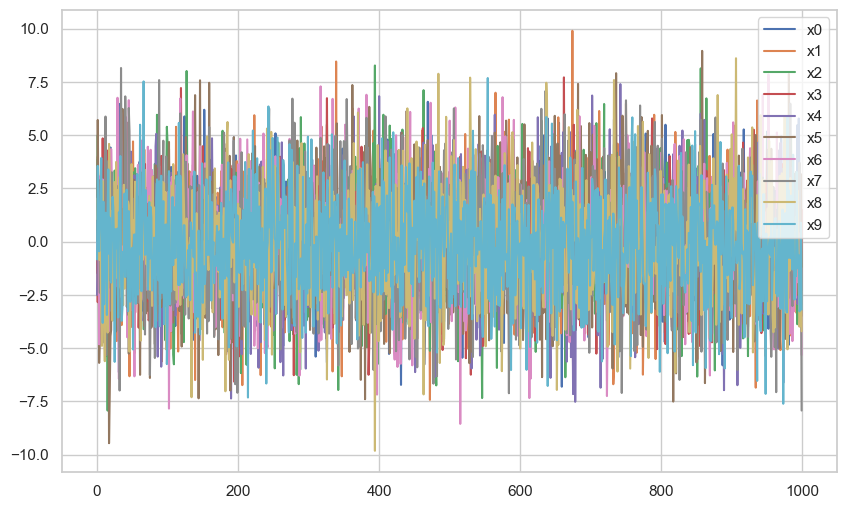

In [135]:
# If you want to visualize a small part of the data
sampled_df = pd.DataFrame(data=X_varlingam[:1000], columns=[f'x{i}' for i in range(n_features)])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
for i in range(min(n_features, 10)):  # Visualize only the first 10 variables to keep the plot readable
    plt.plot(sampled_df[f'x{i}'], label=f'x{i}')
plt.legend()
# Save the plot as a PDF file
plt.savefig('plot.pdf')
plt.show()


In [133]:
# Create a DataFrame with the generated data (optional, might be too large to handle efficiently)
df = pd.DataFrame(data=X_varlingam, columns=[f'x{i}' for i in range(n_features)])

# Display the first 5 rows of the DataFrame (optional, might be too large to handle efficiently)
print(df.head(150))

# Save the generated data to a file (optional)
df.to_csv('varlingam_data.csv', index=False)


           x0        x1        x2        x3        x4        x5        x6  \
0    0.413496 -1.470413  1.089883 -0.202889 -2.499875  0.511930  0.047984   
1    3.869593  3.988099  5.001196 -2.840795 -0.596747  5.710182 -0.734998   
2    1.062727  1.568444  1.069313 -0.378062 -1.517697  1.620344  3.006897   
3    0.732082  0.122337  2.853956  1.517870  2.555023 -5.689006 -4.814583   
4    2.251220  2.099086 -1.285146  0.551566  1.350191 -4.337047 -1.971279   
..        ...       ...       ...       ...       ...       ...       ...   
145  0.193541 -1.155273 -4.062405 -0.911767 -4.649423 -1.592481  1.045618   
146 -2.135321 -0.224979 -1.252316 -0.704937 -0.352395  7.570795  4.475507   
147  0.714175  1.590080  0.606565 -0.296042 -1.318228  0.631304  0.372706   
148 -0.727087 -2.766523 -1.563945  0.068127 -0.753312  1.228668 -1.147877   
149 -2.205543 -4.080558 -0.366879 -2.649496  2.079395  2.284038  0.148272   

           x7        x8        x9  ...      x990      x991      x992  \
0  

In [129]:
B0 = [
    [0,-0.12,0,0,0],
    [0,0,0,0,0],
    [-0.41,0.01,0,-0.02,0],
    [0.04,-0.22,0,0,0],
    [0.15,0,-0.03,0,0],
]
B1 = [
    [-0.32,0,0.12,0.32,0],
    [0,-0.35,-0.1,-0.46,0.4],
    [0,0,0.37,0,0.46],
    [-0.38,-0.1,-0.24,0,-0.13],
    [0,0,0,0,0],
]
causal_order = [1, 0, 3, 2, 4]

# data generated from B0 and B1
X = pd.read_csv('data/sample_data_var_lingam.csv')
#X = pd.read_csv('data/5vars_var.csv')
X
X=df
X

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x990,x991,x992,x993,x994,x995,x996,x997,x998,x999
0,0.413496,-1.470413,1.089883,-0.202889,-2.499875,0.511930,0.047984,0.029243,1.055783,-0.833188,...,-1.612705,-0.742924,1.347091,-1.080783,0.357394,-2.634334,-0.180710,-2.098596,1.534689,0.881163
1,3.869593,3.988099,5.001196,-2.840795,-0.596747,5.710182,-0.734998,0.987195,2.047594,3.554729,...,-1.896659,0.390635,1.105486,-0.243567,0.965590,-4.276278,2.068864,1.395672,-0.201565,-0.002942
2,1.062727,1.568444,1.069313,-0.378062,-1.517697,1.620344,3.006897,-0.137829,1.001426,1.128750,...,2.115657,0.523932,0.753982,-0.276656,2.035428,-1.088464,3.752682,0.116962,-5.428929,-0.923352
3,0.732082,0.122337,2.853956,1.517870,2.555023,-5.689006,-4.814583,1.186287,-0.853422,-0.451951,...,2.859718,0.425883,-1.889515,3.877270,-2.762004,-2.267818,0.614205,3.646235,-0.896509,-0.451877
4,2.251220,2.099086,-1.285146,0.551566,1.350191,-4.337047,-1.971279,-2.397886,1.702208,0.823068,...,4.676451,-1.595785,-0.952614,1.495290,1.834316,-4.849670,-1.006452,3.701684,2.290598,-1.485733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.192831,0.447943,-4.262942,-1.331309,0.893136,-0.413624,0.496720,-5.513472,-0.616344,1.336466,...,-1.743083,-3.647015,2.975232,-1.860296,-1.293085,2.487085,-2.258153,1.138560,-1.516190,-2.253203
9996,0.214775,2.544346,-1.287653,0.465586,-3.039605,-2.803930,0.561223,2.164810,-0.272233,1.447840,...,1.988843,0.479204,-2.121199,-2.698856,1.310490,0.346684,1.711551,0.538909,-3.094070,0.013413
9997,0.898999,1.442644,-0.233624,-1.716152,2.713352,-3.421982,1.029510,-1.404396,0.443766,-0.769551,...,-2.525313,-3.946077,1.311665,-1.957535,-1.742621,3.602004,-4.585826,-1.912051,1.636587,-1.866469
9998,0.177840,-0.361738,-2.290221,-2.027570,-4.063763,-0.693614,1.207903,-0.004066,1.003384,-0.913008,...,-2.924713,-4.110271,-8.995823,-0.563855,-0.343237,4.323016,-4.187184,-4.024445,6.045080,-0.330758


## Causal Discovery
To run causal discovery, we create a `VARLiNGAM` object and call the `fit` method.

In [130]:
model = lingam.VARLiNGAM()
model.fit(X)

KeyboardInterrupt: 

Using the `causal_order_` properties, we can see the causal ordering as a result of the causal discovery.

In [92]:
model.causal_order_

[1, 0, 3, 2, 4]

Also, using the `adjacency_matrices_` properties, we can see the adjacency matrix as a result of the causal discovery.

In [93]:
# B0
model.adjacency_matrices_[0]

array([[ 0.   , -0.095,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.405,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.068, -0.245,  0.   ,  0.   ,  0.   ],
       [ 0.161,  0.   ,  0.   ,  0.   ,  0.   ]])

In [94]:
# B1
model.adjacency_matrices_[1]

array([[-0.325,  0.   ,  0.113,  0.359,  0.   ],
       [ 0.   , -0.351, -0.081, -0.479,  0.381],
       [ 0.   ,  0.   ,  0.342,  0.   ,  0.401],
       [-0.403, -0.097, -0.244,  0.   , -0.085],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [95]:
model.residuals_

array([[ 0.35 , -0.13 ,  1.308,  2.663, -0.275],
       [ 0.791,  0.105, -0.097,  1.849, -1.975],
       [-1.459, -3.113,  1.664,  1.513,  1.014],
       ...,
       [ 0.446,  0.062,  1.948, -1.974, -1.161],
       [-0.756, -0.868, -0.411, -0.898,  0.369],
       [-0.66 , -0.851, -0.709, -0.068,  2.478]])

Using `DirectLiNGAM` for the `residuals_` properties, we can calculate B0 matrix.

In [96]:
dlingam = lingam.DirectLiNGAM()
dlingam.fit(model.residuals_)
dlingam.adjacency_matrix_

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.403,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.243,  0.   ,  0.   ,  0.   ],
       [ 0.131,  0.   ,  0.   ,  0.   ,  0.   ]])

We can draw a causal graph by utility funciton.

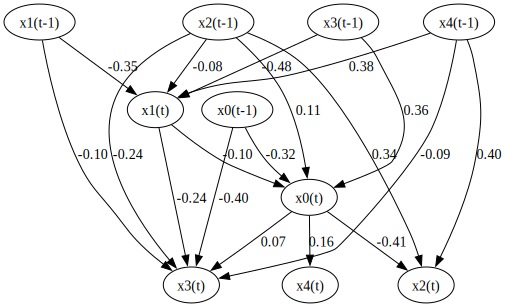

In [88]:
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
#labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)']
# labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x5(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)', 'x5(t-1)']
dot = make_dot(np.hstack(model.adjacency_matrices_), ignore_shape=True, lower_limit=0.05, labels=labels)


# Save pdf
dot.render('dag')

# Save png
dot.format = 'png'
dot.render('dag')

dot

## Independence between error variables
To check if the LiNGAM assumption is broken, we can get p-values of independence between error variables. The value in the i-th row and j-th column of the obtained matrix shows the p-value of the independence of the error variables $e_i$ and $e_j$.

In [65]:
p_values = model.get_error_independence_p_values()
print(p_values)

[[0.    0.127 0.104 0.042 0.746]
 [0.127 0.    0.086 0.874 0.739]
 [0.104 0.086 0.    0.404 0.136]
 [0.042 0.874 0.404 0.    0.763]
 [0.746 0.739 0.136 0.763 0.   ]]


## Bootstrap

### Bootstrapping
We call `bootstrap()` method instead of `fit()`. Here, the second argument specifies the number of bootstrap sampling.

In [11]:
model = lingam.VARLiNGAM()
result = model.bootstrap(X, n_sampling=100)

## Causal Directions
Since `BootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.3 or more.

In [12]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.3, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [13]:
print_causal_directions(cdc, 100, labels=labels)

x2(t) <--- x4(t-1) (b>0) (100.0%)
x2(t) <--- x2(t-1) (b>0) (100.0%)
x0(t) <--- x0(t-1) (b<0) (95.0%)
x1(t) <--- x1(t-1) (b<0) (86.0%)
x1(t) <--- x4(t-1) (b>0) (85.0%)
x3(t) <--- x0(t-1) (b<0) (78.0%)
x2(t) <--- x4(t) (b<0) (60.0%)
x0(t) <--- x3(t-1) (b>0) (48.0%)


## Directed Acyclic Graphs
Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.2 or more.

In [14]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.2, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [62]:
print_dagc(dagc, 100, labels=labels)

DAG[0]: 6.0%
	x0(t) <--- x2(t-1) (b<0)
	x1(t) <--- x3(t-1) (b>0)
	x2(t) <--- x1(t-1) (b<0)
	x3(t) <--- x2(t-1) (b>0)
	x3(t) <--- x4(t-1) (b>0)
	x4(t) <--- x1(t) (b<0)
	x4(t) <--- x3(t) (b>0)
	x4(t) <--- x0(t-1) (b<0)
	x4(t) <--- x1(t-1) (b<0)
	x4(t) <--- x2(t-1) (b<0)
DAG[1]: 6.0%
	x0(t) <--- x2(t-1) (b<0)
	x1(t) <--- x3(t-1) (b>0)
	x2(t) <--- x1(t-1) (b<0)
	x3(t) <--- x2(t-1) (b>0)
	x4(t) <--- x1(t) (b<0)
	x4(t) <--- x3(t) (b>0)
	x4(t) <--- x0(t-1) (b<0)
	x4(t) <--- x1(t-1) (b<0)
	x4(t) <--- x2(t-1) (b<0)
DAG[2]: 4.0%
	x0(t) <--- x1(t) (b<0)
	x0(t) <--- x2(t-1) (b<0)
	x1(t) <--- x3(t-1) (b>0)
	x2(t) <--- x3(t) (b>0)
	x2(t) <--- x1(t-1) (b<0)
	x3(t) <--- x2(t-1) (b>0)
	x4(t) <--- x1(t) (b<0)
	x4(t) <--- x3(t) (b>0)
	x4(t) <--- x0(t-1) (b<0)
	x4(t) <--- x1(t-1) (b<0)
	x4(t) <--- x2(t-1) (b<0)


## Probability
Using the `get_probabilities()` method, we can get the probability of bootstrapping.

In [63]:
prob = result.get_probabilities(min_causal_effect=0.1)
print('Probability of B0:\n', prob[0])
print('Probability of B1:\n', prob[1])

Probability of B0:
 [[0.   0.23 0.05 0.02 0.02]
 [0.65 0.   0.09 0.13 0.06]
 [0.   0.18 0.   0.36 0.13]
 [0.41 0.16 0.48 0.   0.12]
 [0.07 0.94 0.39 0.88 0.  ]]
Probability of B1:
 [[0.03 0.81 1.   0.5  0.02]
 [0.06 0.06 0.11 0.9  0.02]
 [0.   1.   0.07 0.03 0.65]
 [0.1  1.   1.   0.18 0.86]
 [1.   0.99 1.   0.06 0.04]]


## Total Causal Effects
Using the `get_causal_effects()` method, we can get the list of total causal effect. The total causal effects we can get are dictionary type variable.
We can display the list nicely by assigning it to pandas.DataFrame. Also, we have replaced the variable index with a label below.

In [44]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)
df = pd.DataFrame(causal_effects)

df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,x0(t-1),x4(t),-63.186017,1.00
1,x3(t-1),x2(t),-6.767336,1.00
2,x4(t-1),x2(t),1.270818,1.00
3,x4(t-1),x5(t),3.151725,1.00
4,x0(t-1),x3(t),-2.275083,1.00
...,...,...,...,...
61,x0(t),x2(t),2.027842,0.31
62,x5(t),x3(t),0.066527,0.28
63,x0(t),x3(t),0.272175,0.27
64,x1(t),x4(t),2.237439,0.27


We can easily perform sorting operations with pandas.DataFrame.

In [45]:
df.sort_values('effect', ascending=False).head()

,from,to,effect,probability
48,x3(t),x1(t),14.836681,0.53
58,x0(t),x4(t),6.267577,0.34
8,x1(t-1),x1(t),6.195928,1.00
24,x1(t-1),x4(t),6.088007,1.00
44,x3(t),x2(t),6.077103,0.57


And with pandas.DataFrame, we can easily filter by keywords. The following code extracts the causal direction towards x1(t).

In [46]:
df[df['to']=='x1(t)'].head()

,from,to,effect,probability
5,x4(t-1),x1(t),4.815899,1.00
6,x3(t-1),x1(t),-27.044629,1.00
8,x1(t-1),x1(t),6.195928,1.00
9,x0(t-1),x1(t),-63.035856,1.00
25,x5(t-1),x1(t),2.601362,0.99


Because it holds the raw data of the total causal effect (the original data for calculating the median), it is possible to draw a histogram of the values of the causal effect, as shown below.

(array([ 5., 13.,  9.,  8., 12., 15., 23., 10.,  2.,  3.]),
 array([1.089, 1.186, 1.282, 1.378, 1.475, 1.571, 1.668, 1.764, 1.86 ,
        1.957, 2.053]),
 <BarContainer object of 10 artists>)

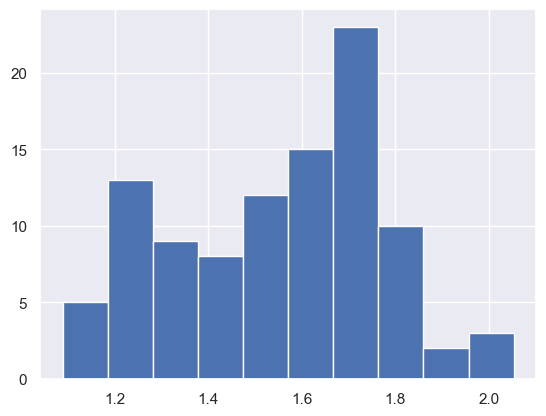

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from_index = 7 # index of x2(t-1). (index:2)+(n_features:5)*(lag:1) = 7
to_index = 2 # index of x2(t). (index:2)+(n_features:5)*(lag:0) = 2
plt.hist(result.total_effects_[:, to_index, from_index])